In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import torchvision.models as models
import timm
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torchvision.ops import sigmoid_focal_loss
from transformers import DeiTForImageClassification, AutoImageProcessor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

print("class_to_idx:", train_dataset.class_to_idx)

processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224", weights_only=True)
model = DeiTForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224", weights_only=False
)
model.to(device)

class_to_idx: {'Negative': 0, 'Positive': 1}


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          

In [5]:
for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 1).to(device)

model.classifier.requires_grad_(True)
optimizer = optim.Adam(
    list(model.classifier.parameters()),
    lr=1e-3
)

def focal_criterion(logits, targets, alpha=0.25, gamma=2.0):
    return sigmoid_focal_loss(
        inputs=logits,
        targets=targets,
        alpha=alpha,
        gamma=gamma,
        reduction="mean"
    )

In [6]:

def train_one_epoch():
    model.train()
    total_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc="Training", leave=False):
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (N,1)

        out = model(pixel_values=imgs)
        logits = out.logits

        loss = focal_criterion(logits, labels, alpha=0.25, gamma=2.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        out = model(pixel_values=imgs)
        logits = out.logits

        loss = focal_criterion(logits, labels, alpha=0.25, gamma=2.0)
        total_loss += loss.item() * imgs.size(0)

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()
        correct += (preds.cpu() == labels.cpu().long().squeeze(1)).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total
    return acc, avg_loss


In [7]:
epochs = 10
for epoch in range(epochs):
    train_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Acc: {acc:.3f}")


Epoch 1/10 | Train loss: 0.0551 | Val loss: 0.0449 | Acc: 0.728


Epoch 2/10 | Train loss: 0.0415 | Val loss: 0.0379 | Acc: 0.806


Epoch 3/10 | Train loss: 0.0349 | Val loss: 0.0391 | Acc: 0.751


Epoch 4/10 | Train loss: 0.0330 | Val loss: 0.0361 | Acc: 0.843


Epoch 5/10 | Train loss: 0.0305 | Val loss: 0.0329 | Acc: 0.797


Epoch 6/10 | Train loss: 0.0296 | Val loss: 0.0333 | Acc: 0.857


Epoch 7/10 | Train loss: 0.0284 | Val loss: 0.0316 | Acc: 0.834


Epoch 8/10 | Train loss: 0.0275 | Val loss: 0.0310 | Acc: 0.843


Epoch 9/10 | Train loss: 0.0265 | Val loss: 0.0306 | Acc: 0.843


Epoch 10/10 | Train loss: 0.0262 | Val loss: 0.0302 | Acc: 0.843


              precision    recall  f1-score   support

    Negative     0.8361    0.9745    0.9000       157
    Positive     0.8824    0.5000    0.6383        60

    accuracy                         0.8433       217
   macro avg     0.8592    0.7373    0.7691       217
weighted avg     0.8489    0.8433    0.8276       217

Confusion Matrix:
 [[153   4]
 [ 30  30]]


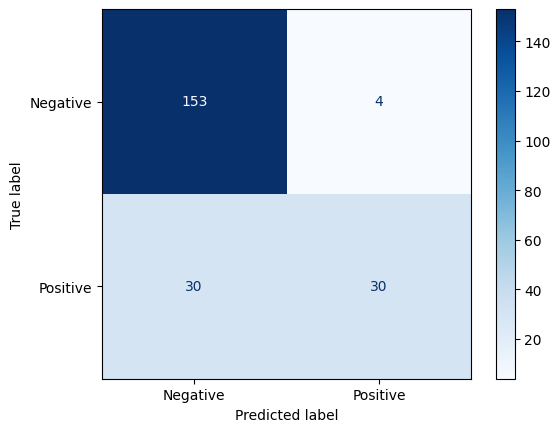

In [9]:
@torch.no_grad()
def evaluate_predictions():
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(pixel_values=imgs)
        logits = out.logits

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
    return all_labels, all_preds


# ---- Generate reports ----
labels, preds = evaluate_predictions()

# Classification report (precision, recall, f1)
print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

# Optional: visualize it
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
